**Prediction of the value of dollar in Mexicans pesos using ARIMA and Prophet**

The data was download from Mexicans Bank(Banxico)

https://www.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?sector=6&accion=consultarCuadro&idCuadro=CF373&locale=es

In [74]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score
from selenium.webdriver import Chrome
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os
from itertools import product

In [75]:
website = 'https://www.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?sector=6&accion=consultarCuadro&idCuadro=CF373&locale=es';
path = 'chromedriver_win32/chromedriver.exe'
driver = Chrome(executable_path=path)
driver.get(website)

time_series_button = driver.find_element_by_xpath('//*[@id="exportarSeriesFormatoXLS"]')
time_series_button.click()
time.sleep(10)

In [76]:
path = r'C:/Users/dell/Dropbox/PC/Downloads/'

for file_name in os.listdir(path):
    if file_name.endswith('.xlsx'):
       file_path = path + f"{file_name}"
       break

while not os.path.exists(file_path):
    time.sleep(1)

if os.path.isfile(file_path):
    df = pd.read_excel(f"{file_path}", index_col=0,parse_dates=True,skiprows = 17) 
    driver.close()
    os.remove(f"{file_path}")
else:
    raise ValueError("%s isn't a file!" % file_path)

In [77]:
data = df.copy()

In [78]:
data.head()

,SF63528
Fecha,
1954-04-19,0.0125
1954-04-20,0.0125
1954-04-21,0.0125
1954-04-22,0.0125
1954-04-23,0.0125


In [79]:
def preprocesing_data(df):
    df.rename(columns={'SF63528' : 'price'} , inplace= True)
    df = df.sort_index()
    df = df.asfreq('b')
    df.interpolate(inplace=True)
    mask = df.index.year >=2022
    df = df[mask]
                 
                 
    return df

In [80]:
data = preprocesing_data(data)
data.head()

,price
Fecha,
2022-01-03,20.5890
2022-01-04,20.4742
2022-01-05,20.3977
2022-01-06,20.4588
2022-01-07,20.4237


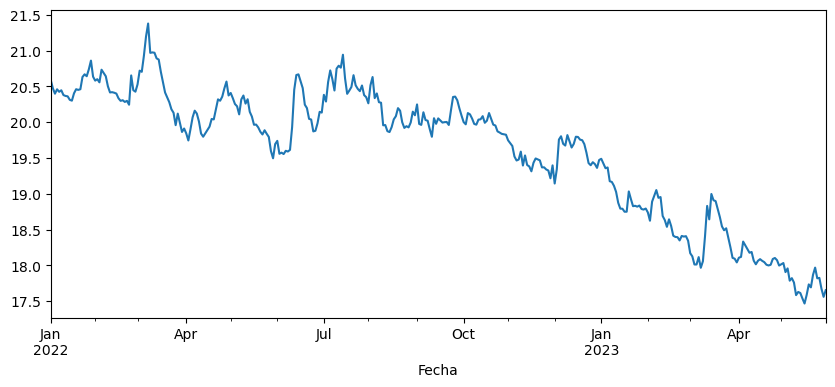

In [81]:
fig, axis = plt.subplots(1,1, figsize = (10,4))
data['price'].plot(ax = axis)
plt.show()

**Decompose the time serie into its trend, seasonality and residues**



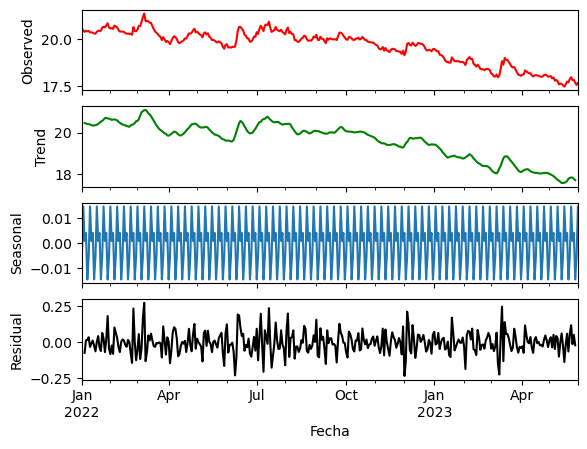

In [82]:
# ____Additive decomposition_____

dec_ts_add = seasonal_decompose(data.price, model="additive")

fig, axes = plt.subplots(4, 1, sharex = True)
dec_ts_add .observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
dec_ts_add.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
dec_ts_add .seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
dec_ts_add.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
plt.show()

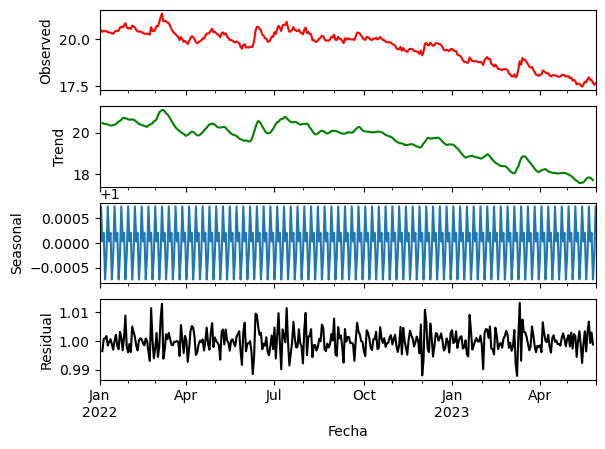

In [83]:
# ____Multiplicative decomposition_____

dec_ts_mul = seasonal_decompose(data.price, model="multiplicative")

fig, axes = plt.subplots(4, 1, sharex = True)
dec_ts_mul .observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
dec_ts_add.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
dec_ts_mul .seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
dec_ts_mul.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
plt.show()

Note that the seasonal component is almost zero. Therefore, we do no consider it for the modeling structure.

**Verify the stationarity**

In [84]:
test = adfuller(data['price'])[1]
if test > 0.05 :
    print("It's no stationary")
else:
    print("It's stationary")


It's no stationary


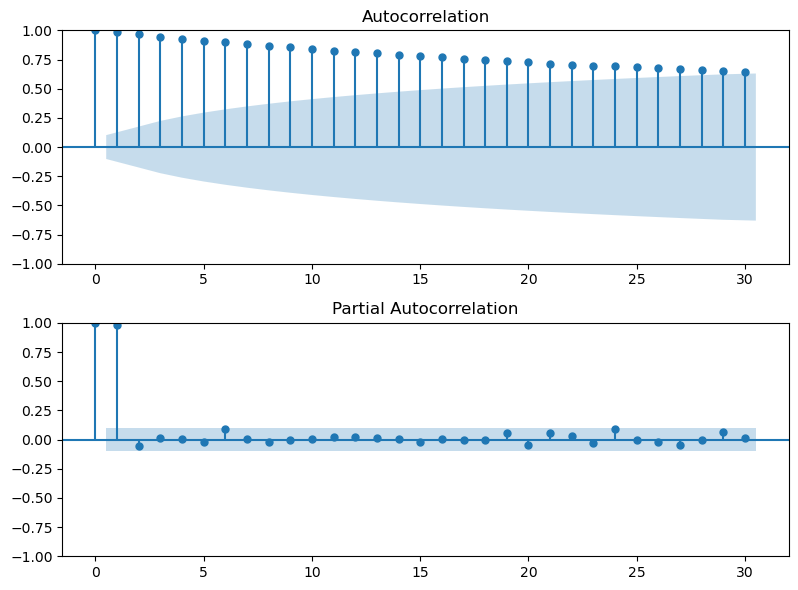

In [85]:
fig, axis = plt.subplots(2,1, figsize = (8,6))
plot_acf(data.price, lags=30, alpha = 0.05, ax = axis[0])
plot_pacf(data.price, lags=30, alpha = 0.05, ax = axis[1])
plt.tight_layout()

**Mean average**

In [86]:
data['DESadd12'] = ExponentialSmoothing(data['price'], trend = 'add',seasonal = 'mul').fit().fittedvalues

model_mul = ExponentialSmoothing(data['price'], trend = 'mul',seasonal = 'mul').fit()
forescast_mul = model_mul.forecast(36)
model_add = ExponentialSmoothing(data['price'], trend = 'add',seasonal = 'mul').fit()

forescast_add = model_add.forecast(36)

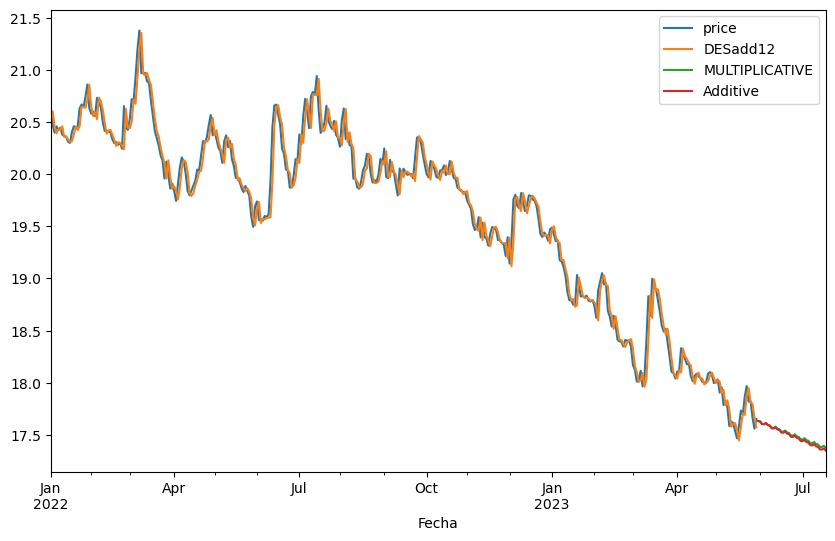

In [87]:
data.plot(figsize=(10,6))
forescast_mul.plot(label = 'MULTIPLICATIVE')
forescast_add.plot(label = 'Additive')
plt.legend()
plt.show()

The forecast of ExponentialSmoothing seems to have a decreasing trend

In [88]:
datos = data['price'].copy().to_frame()

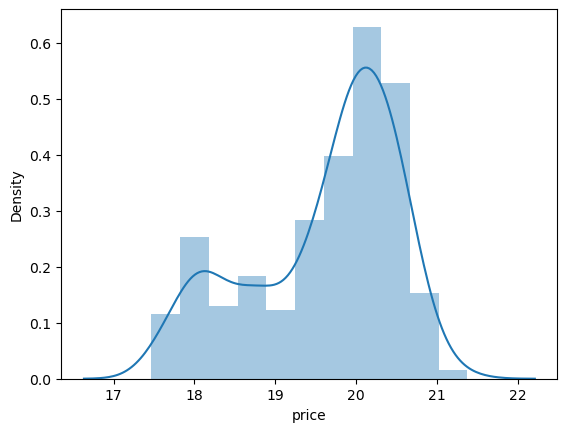

In [89]:
sns.distplot(datos['price'])
plt.show()

#The symmetry of the price is skewed left

In [90]:
limit = 30
train, test = datos.iloc[:-limit], datos.iloc[-limit:]

In [91]:
def rolling_optimize(endog: pd.DataFrame, len_train: int )->pd.DataFrame:
    p,q = list(range(0,5,1)),list(range(0,5,1))
    d = list(range(0,2,1))
    orders = list(product(p,d,q))
    metric = []
    for order in orders:
        model = (SARIMAX(endog[:len_train], 
                        order=(order[0], order[1], order[2]),
                        simple_differencing=False)
                        .fit(disp=False)
                  )
        aic = model.aic
        metric.append([order,aic])

    metric_df = pd.DataFrame(metric, 
                             columns=['order', 'AIC']
                             )
    metric_df = (metric_df
                        .sort_values(by='AIC', ascending=True)
                        .reset_index(drop=True)
                )

    return metric_df   

In [92]:
LEN_TRAIN = len(train)
df_m = rolling_optimize(datos['price'], LEN_TRAIN)
df_m.head(5)

,order,AIC
0,"(0, 1, 0)",-440.006889
1,"(1, 1, 0)",-439.242346
2,"(0, 1, 1)",-439.199476
3,"(1, 1, 1)",-437.347459
4,"(2, 1, 0)",-437.335103


**Multi-stepping**

In [93]:
def rolling_forecasting(endog:pd.DataFrame, len_train:int, total_len:int,  steps: int)->list:
    get_pred = []
    for i in range(len_train, total_len, steps):
        model = SARIMAX(endog[:i], order=(1,1,1))
        res = model.fit(disp = False)
        predictions = res.get_prediction(0,i + steps - 1)
        pred = predictions.predicted_mean.iloc[-steps:]
        get_pred.extend(pred)
    
    return get_pred

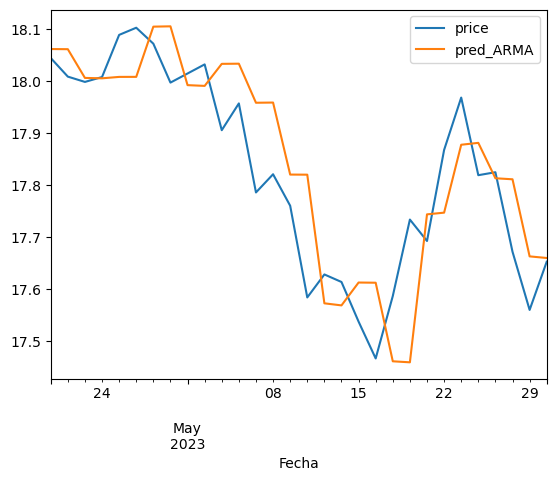

In [94]:
STEPS = 2
TRAIN_LEN = len(train)
TOTAL_LEN = len(datos)
pred_ARMA = rolling_forecasting(datos['price'], TRAIN_LEN, TOTAL_LEN, STEPS)
test.loc[:, 'pred_ARMA'] = pred_ARMA
test[['price','pred_ARMA']].plot()
plt.show()

In [95]:
test[['price','pred_ARMA']]
r2 = r2_score(test['price'], test['pred_ARMA'])

print(f"The coefficient of Determination R^2: {r2}")

The coefficient of Determination R^2: 0.6769564163762547


**Prophet**

In [96]:
# Using the Prophet library to find out the confident interval
from prophet import Prophet

In [97]:
data_p = ( data
            .reset_index()[['Fecha', 'price']]
            .rename(columns = {"Fecha": 'ds', 'price': 'y'})

)
data_p.head()

,ds,y
0,2022-01-03,20.5890
1,2022-01-04,20.4742
2,2022-01-05,20.3977
3,2022-01-06,20.4588
4,2022-01-07,20.4237


In [98]:
pd.plotting.register_matplotlib_converters()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


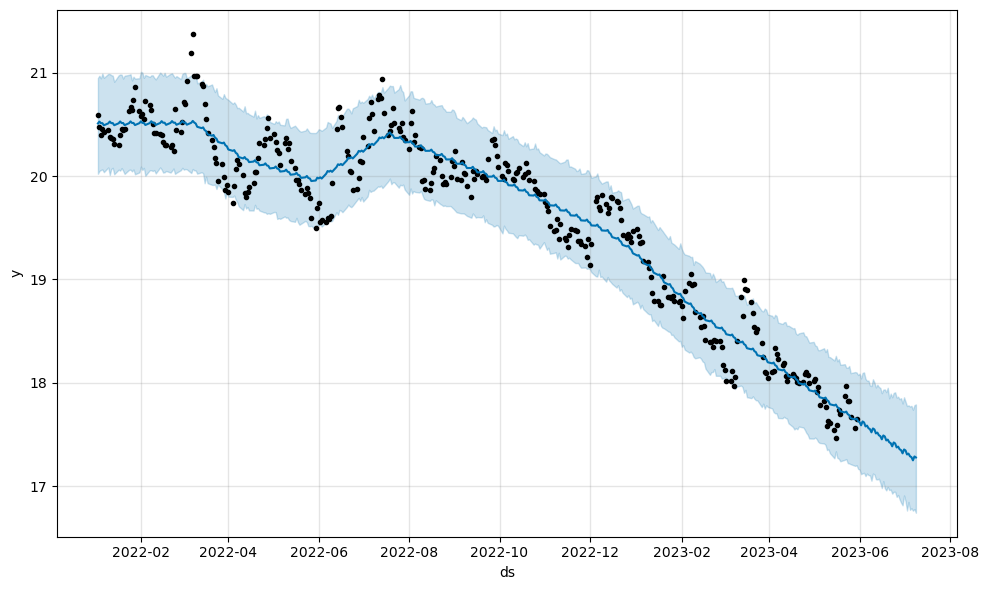

In [99]:
m = Prophet(interval_width=0.95)
m.fit(data_p)
future = m.make_future_dataframe(periods=40, freq = 'D')
forecast = m.predict(future)
m.plot(forecast);

Prophet aims the decreasing trend of the price of Mexican peso regarding USD